In [9]:
import sys
sys.path.append("..")
from flame_analysis_model import *
import torch
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [11]:

comm = MPI.COMM_WORLD
rank = comm.rank

time_step = 120
folder_name = "data/old_phi0.40_h100"#"data/v6"#
file_name = "po_premix"
# Geometry / reference file (constant)

# Communicator for parallelization
comm = MPI.COMM_WORLD

# 2) Load dataset
scalars = [
    'H2','O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
    'curvature', 'stretch_rate', 'disp_speed_density_weighted',
    'abs_flame_prop_vel_normal', 'flow_velocity_normal',
    'flow_velocity_tangential', 'tangential_strain_rate',
    'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
    'vorticity'
]
ds = SEMDataset(file_name=file_name, folder_name= folder_name,time_step= time_step, comm=MPI.COMM_WORLD, scalar_names=scalars)
df = ds.create_dataframe(
    compute_vel_jacobian= False,
    compute_vel_hessian= False,
    compute_reaction_rates= False,
    cantera_inputs = ["BurkeH2.yaml", None, 0.5, 300, 5e05]
)

2025-11-25 10:15:05,074 - Mesh - INFO - Initializing empty Mesh object.
2025-11-25 10:15:05,080 - Field - INFO - Initializing empty Field object
2025-11-25 10:15:05,084 - pynekread - INFO - Reading file: ./data/old_phi0.40_h100/po_premix0.f00001
2025-11-25 10:15:05,152 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-11-25 10:15:05,154 - Mesh - INFO - Initializing common attributes.
2025-11-25 10:15:05,158 - Mesh - INFO - Getting vertices
2025-11-25 10:15:05,167 - Mesh - INFO - Getting edge centers
2025-11-25 10:15:05,248 - Mesh - INFO - Facet centers not available for 2D
2025-11-25 10:15:05,249 - Mesh - INFO - Mesh object initialized.
2025-11-25 10:15:05,253 - Mesh - INFO - Mesh data is of type: float64
2025-11-25 10:15:05,254 - Mesh - INFO - Elapsed time: 0.10213529999600723s
2025-11-25 10:15:05,255 - pynekread - INFO - Reading field data
2025-11-25 10:15:05,256 - pynekread - INFO - Overwriting fld object
2025-11-25 10:15:05,827 - pynekread - INFO - File read
2025-1

In [12]:

front = ds.extract_flame_front_new(
    sample_mode= "isocontour",
    c_level= 3.5,
)
print(front)
print("Extarcted flame front")
front.to_csv(f"extracted_flame_front_{time_step}.csv", index=False)

               x          y    z  temp        H2        O2       H2O  \
0     345.108456  50.186360  0.0   3.5  0.000040  0.176700  0.069967   
1     345.073181  50.548154  0.0   3.5  0.000040  0.176690  0.069959   
2     345.013631  50.376839  0.0   3.5  0.000041  0.176665  0.069920   
3     344.961395  50.664563  0.0   3.5  0.000041  0.176657  0.069901   
4     344.942186  50.503932  0.0   3.5  0.000041  0.176646  0.069885   
...          ...        ...  ...   ...       ...       ...       ...   
4094  283.278910  20.916025  0.0   3.5  0.002246  0.170866  0.071377   
4095  283.336763  20.816735  0.0   3.5  0.002404  0.167928  0.072556   
4096  283.344117  20.803104  0.0   3.5  0.002233  0.170710  0.071465   
4097  283.432331  20.649066  0.0   3.5  0.002220  0.170932  0.071374   
4098  283.432519  20.648911  0.0   3.5  0.002218  0.170952  0.071367   

                 H         O        OH  ...  stretch_rate  \
0     5.354853e-08  0.000007  0.000022  ...     -5.507097   
1     5.49909

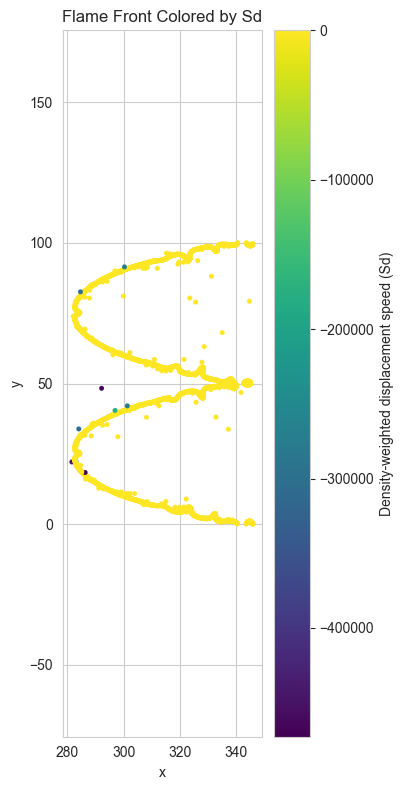

In [13]:
plt.figure(figsize=(4, 8))

sc = plt.scatter(
    front["x"],
    front["y"],
    c = front["disp_speed_density_weighted"],
    cmap = "viridis",
    s = 12,
    linewidths = 0.1
)

plt.axis("equal")
plt.colorbar(sc, label="Density-weighted displacement speed (Sd)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Flame Front Colored by Sd")
plt.tight_layout()
plt.show()


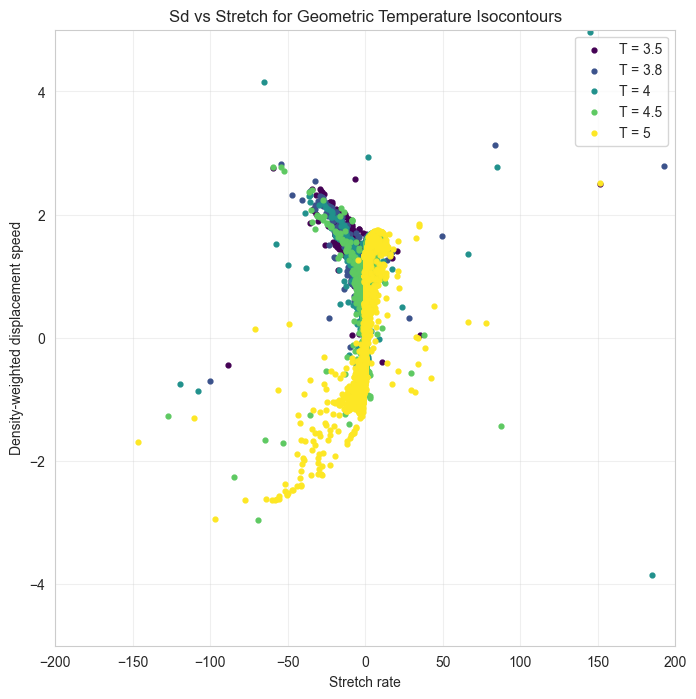

In [14]:
isocon_list = [ 3.5, 3.8, 4, 4.5, 5]

plt.figure(figsize=(8, 8))

cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(isocon_list)))

for i, iso in enumerate(isocon_list):

    # Extract the flame front for this isocontour
    isoline = ds.extract_flame_front_new(
        sample_mode="isocontour",
        c_level=iso,
    )

    x = isoline["stretch_rate"].to_numpy()
    y = isoline["disp_speed_density_weighted"].to_numpy()

    plt.scatter(x, y, s=12, color=colors[i], label=f"T = {iso}")

    # Fit a line if possible
    # if len(x) > 2:
    #     coeffs = np.polyfit(x, y, deg=1)
    #     x_line = np.linspace(x.min(), x.max(), 200)
    #     y_line = coeffs[0] * x_line + coeffs[1]
    #     plt.plot(x_line, y_line, color=colors[i], linewidth=2)

plt.xlabel("Stretch rate")
plt.ylabel("Density-weighted displacement speed")
plt.ylim((-5, 5))
plt.xlim((-200,200))
plt.title("Sd vs Stretch for Geometric Temperature Isocontours")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


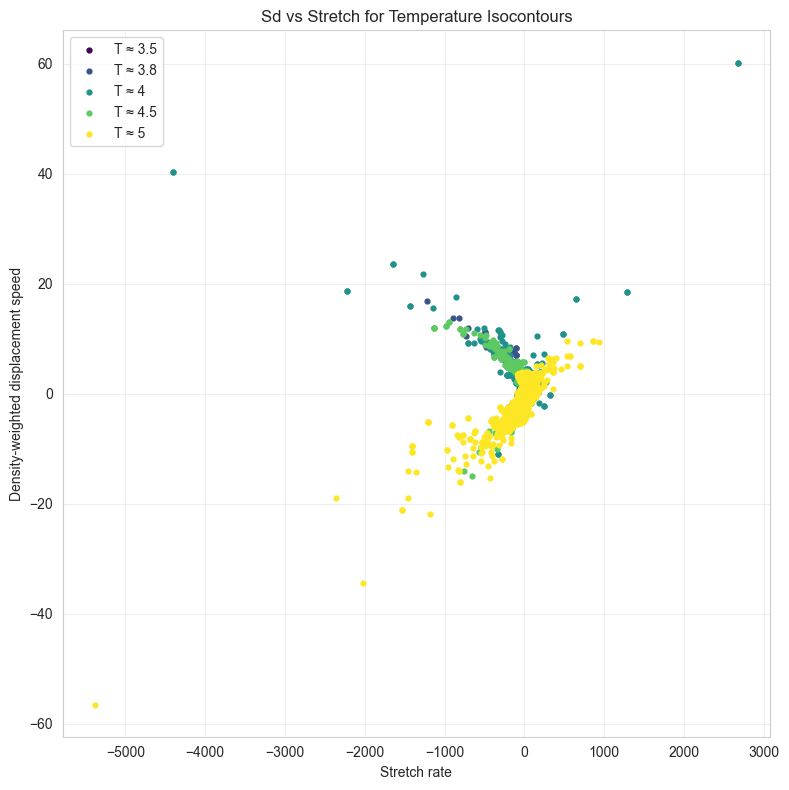

In [15]:
isocon_list = [ 3.5, 3.8, 4, 4.5, 5]
tol = 0.1

plt.figure(figsize=(8, 8))

cmap = plt.cm.viridis  # choose your preferred colormap
colors = cmap(np.linspace(0, 1, len(isocon_list)))

for i, iso in enumerate(isocon_list):
    # Select iso-line slice
    iso_df = df[(df["T"] > (iso - tol)) & (df["T"] < (iso + tol))]

    x = iso_df["stretch_rate"].to_numpy()
    y = iso_df["disp_speed_density_weighted"].to_numpy()

    # Scatter plot
    plt.scatter(x, y, s=12, color=colors[i], label=f"T ≈ {iso}")

    # Fit line if enough points
    # if len(x) > 2:
    #     coeffs = np.polyfit(x, y, deg=1)
    #     x_line = np.linspace(x.min(), x.max(), 200)
    #     y_line = coeffs[0] * x_line + coeffs[1]
    #     plt.plot(x_line, y_line, color=colors[i], linewidth=2)

plt.xlabel("Stretch rate")
plt.ylabel("Density-weighted displacement speed")
plt.title("Sd vs Stretch for Temperature Isocontours")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


